In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import (ImageList, PointsItemList, get_transforms, ResizeMethod, open_image, Tensor, 
                           tensor, Image, imagenet_stats, Flatten, cnn_learner, models, Path)
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback
from fastprogress import progress_bar
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn.functional import mse_loss

from model_utils import MSELossFlat
from model_utils import Reshape

In [3]:
images_path = '../data/resized_images'
labels_path = '../data/resized_labels.csv'
target_size = 320

In [4]:
y = pd.read_csv(labels_path, index_col='filename')

In [5]:
def get_y_func(x):
    filename = str(x).split('/')[-1]
    coord_list = []
    coords = list(y.loc[filename])
    for i in range(len(coords)//2):
        coord_list.append([coords[i*2+1],coords[i*2]])
    return tensor(coord_list)

In [6]:
transforms = get_transforms(
    do_flip=False,
    max_rotate=45, 
    max_zoom=1.5, 
    max_lighting=0.5, 
    max_warp=0.4, 
    p_affine=1., 
    p_lighting=1.
) 

In [7]:
data = (
    PointsItemList
        .from_folder(images_path)
        .split_by_rand_pct(0.15)
        .label_from_func(get_y_func)
        .transform(
            transforms,
            size=320,
            tfm_y=True, 
            remove_out=False, 
            padding_mode='reflection', 
            resize_method=ResizeMethod.PAD
        )
        .databunch()
        .normalize(imagenet_stats)
)

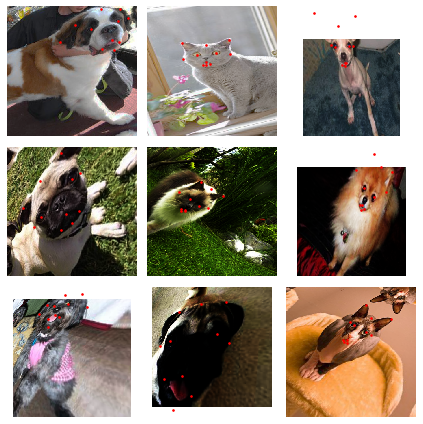

In [8]:
data.show_batch(3, figsize=(6,6))

In [9]:
head_reg = nn.Sequential(
    Flatten(), 
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(51200, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 22),
    Reshape(-1,11,2),
    nn.Tanh()
)

In [10]:
mse_loss_flat = MSELossFlat()

learn = cnn_learner(
    data, 
    models.resnet34, 
    loss_func=mse_loss_flat,
    custom_head=head_reg
).to_fp16()

In [11]:
learn.path = Path('..')

In [12]:
# learn.lr_find()
# learn.recorder.plot()

In [13]:
# learn.freeze_to(-1)
# learn.fit_one_cycle(
#     10, 
#     slice(1e-2), 
#     callbacks=[
#         SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='resnet34_frozen_to_-1'),
#         EarlyStoppingCallback(learn, monitor='valid_loss', min_delta=0.01, patience=10)
#     ]
# )

In [14]:
learn = learn.load('fastai_resnet34')
learn = learn.to_fp32()

In [15]:
# learn.freeze_to(-2)
# learn.fit_one_cycle(
#     10, 
#     slice(1e-3), 
#     callbacks=[
#         SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='resnet34_frozen_to_-2'),
#         EarlyStoppingCallback(learn, monitor='valid_loss', min_delta=0.01, patience=10)
#     ]
# )

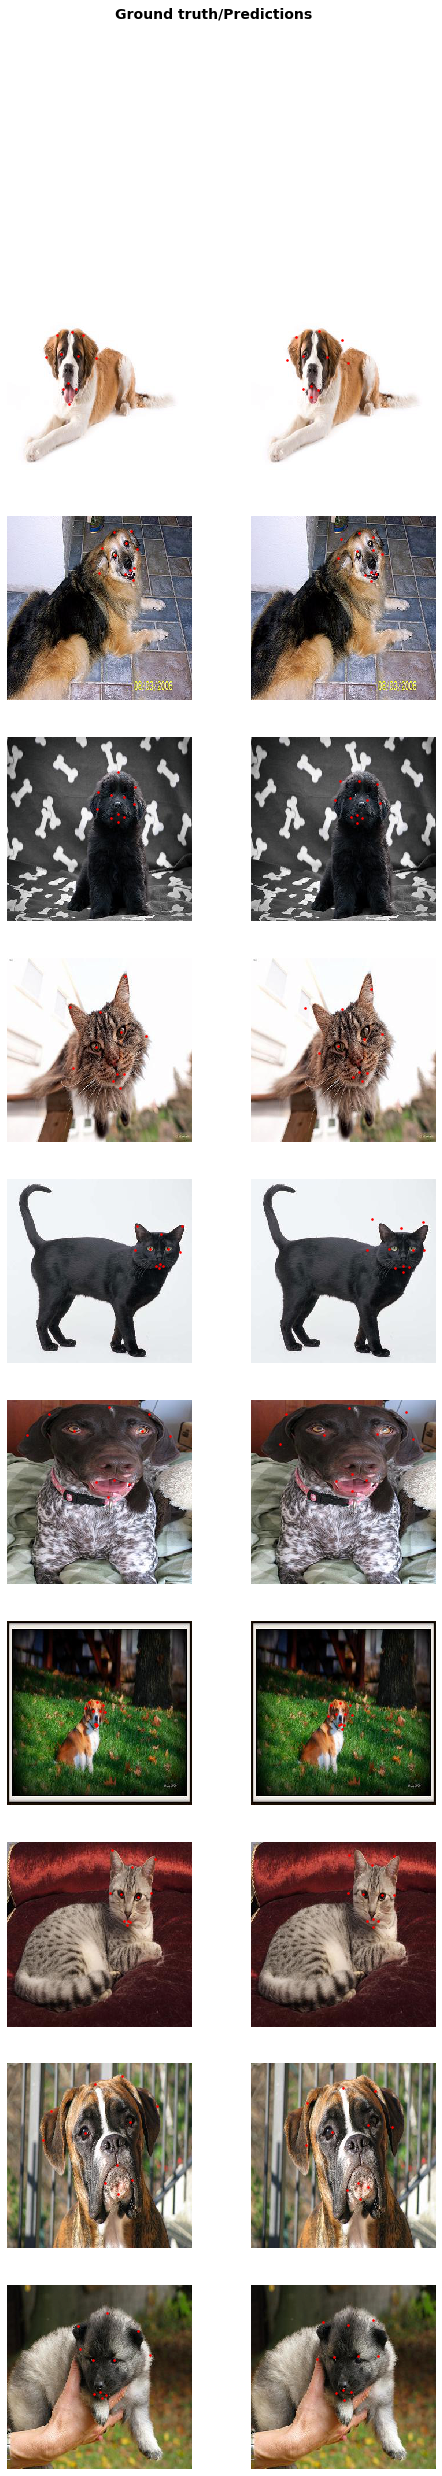

In [16]:
learn.show_results(rows=10)

## Deploy to AWS Lambda

In [17]:
%%writefile pet_regression.py
from bentoml import BentoService, api, env, artifacts 
from bentoml.artifact import FastaiModelArtifact
from bentoml.handlers import FastaiImageHandler

@env(pip_dependencies=['fastai', 'model_utils'])
@artifacts([FastaiModelArtifact('pet_regressor')])
class PetRegression(BentoService):
    
    @api(FastaiImageHandler)
    def predict(self, image):
        result = self.artifacts.pet_regressor.predict(image)
        return str(result)

Overwriting pet_regression.py


In [18]:
# 1) import the custom BentoService defined above
from pet_regression import PetRegression

# 2) `pack` it with required artifacts
service = PetRegression.pack(pet_regressor=learn)

# 3) save your BentoSerivce
saved_path = service.save()

[2019-10-19 15:48:52,415] INFO - Successfully saved Bento 'PetRegression:20191019154821_10E917' to path: /Users/HenryDashwood/bentoml/repository/PetRegression/20191019154821_10E917


In [19]:
from bentoml import load

service = load(saved_path)

print(service.predict(data.get(0)))

[2019-10-19 15:48:58,215] WARNING - Module `pet_regression` already loaded, using existing imported module.
(ImagePoints (320, 320), tensor([[-0.5638, -0.4552],
        [-0.8983, -0.4173],
        [-0.8985, -0.0678],
        [-0.9187,  0.2398],
        [-0.6159,  0.3104],
        [-0.2388, -0.0278],
        [-0.6171, -0.2045],
        [-0.6355,  0.1022],
        [-0.3086, -0.1297],
        [-0.3481, -0.0332],
        [-0.3190,  0.0545]]), tensor([[-0.5638, -0.4552],
        [-0.8983, -0.4173],
        [-0.8985, -0.0678],
        [-0.9187,  0.2398],
        [-0.6159,  0.3104],
        [-0.2388, -0.0278],
        [-0.6171, -0.2045],
        [-0.6355,  0.1022],
        [-0.3086, -0.1297],
        [-0.3481, -0.0332],
        [-0.3190,  0.0545]]))


In [20]:
!pip install {saved_path}

Processing /Users/HenryDashwood/bentoml/repository/PetRegression/20191019154821_10E917
  Stored in directory: /private/var/folders/yl/c5z1v7897q3g9ywlj63pm0840000gn/T/pip-ephem-wheel-cache-fli4d74r/wheels/5a/68/fe/2cc8b33248496adc6b4c19a182c1f24886329ac78d38ef617c
Successfully built PetRegression
  Found existing installation: PetRegression 20191019153554b74222
    Uninstalling PetRegression-20191019153554b74222:
      Successfully uninstalled PetRegression-20191019153554b74222


In [21]:
!PetRegression predict --input=../data/resized_images/Abyssinian_1.jpg

(ImagePoints (320, 320), tensor([[-0.3867,  0.0846],
        [-0.6847,  0.0874],
        [-0.5517,  0.2640],
        [-0.6337,  0.4377],
        [-0.3433,  0.4129],
        [-0.1768,  0.2797],
        [-0.3842,  0.1987],
        [-0.3603,  0.3473],
        [-0.2144,  0.2346],
        [-0.2251,  0.2833],
        [-0.2118,  0.3196]]), tensor([[-0.3867,  0.0846],
        [-0.6847,  0.0874],
        [-0.5517,  0.2640],
        [-0.6337,  0.4377],
        [-0.3433,  0.4129],
        [-0.1768,  0.2797],
        [-0.3842,  0.1987],
        [-0.3603,  0.3473],
        [-0.2144,  0.2346],
        [-0.2251,  0.2833],
        [-0.2118,  0.3196]]))


In [22]:
# !bentoml serve {saved_path}

In [53]:
bento_tag = '{name}:{version}'.format(name=service.name, version=service.version)
print(bento_tag)

PetRegression:20191019154821_10E917


In [57]:
!bentoml --verbose deployment create facial-features-detector --bento {bento_tag} --platform aws-lambda --region us-east-1

[2019-10-19 18:30:56,302] DEBUG - Using BentoML with local Yatai server
[2019-10-19 18:30:56,432] DEBUG - Upgrading tables to the latest revision
[2019-10-19 18:30:56,680] DEBUG - Created temporary directory: /private/var/folders/yl/c5z1v7897q3g9ywlj63pm0840000gn/T/bentoml-temp-rcsbrk64
Traceback (most recent call last):
  File "/Users/HenryDashwood/miniconda3/envs/py37/bin/bentoml", line 10, in <module>
    sys.exit(cli())
  File "/Users/HenryDashwood/miniconda3/envs/py37/lib/python3.7/site-packages/click/core.py", line 764, in __call__
    return self.main(*args, **kwargs)
  File "/Users/HenryDashwood/miniconda3/envs/py37/lib/python3.7/site-packages/click/core.py", line 717, in main
    rv = self.invoke(ctx)
  File "/Users/HenryDashwood/miniconda3/envs/py37/lib/python3.7/site-packages/click/core.py", line 1137, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/Users/HenryDashwood/miniconda3/envs/py37/lib/python3.7/site-packages/click/core.py", line 1137, 

In [52]:
!bentoml deployment list

NAME    NAMESPACE    LABELS    PLATFORM    STATUS    AGE
                               unset       pending   49 years, 50 weeks and 2 days


In [56]:
!bentoml --verbose deployments delete facial-features-detector --force

[2019-10-19 18:30:52,128] DEBUG - Using BentoML with local Yatai server
[2019-10-19 18:30:52,279] DEBUG - Upgrading tables to the latest revision
Successfully deleted deployment "facial-features-detector"
